In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/铁矿期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['铁矿期货价格'].last_valid_index()       

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,铁矿期货价格拟合残差/日均铁水产量超季节性/3年,铁矿期货价格,日均铁水产量超季节性/3年
2025-12-01,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN


In [5]:
#sheet.loc[:last_day, '铁矿期货价格'] = sheet.loc[:last_day, '铁矿期货价格'].interpolate(method='linear')


In [6]:
file_path1 = os.path.expanduser("eta/日均铁水产量超季节性3年_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['实际值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-12-01,3.54
3,2025-12-02,2.10
2,2025-12-03,1.83
1,2025-12-04,2.23
0,2025-12-05,2.90


In [7]:
file_path2 = os.path.expanduser("eta/铁矿期货价格拟合残差_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,预测值
21,2025-10-27,-76.2657
20,2025-10-28,-70.9152
19,2025-10-29,-52.5176
18,2025-10-30,-51.4441
17,2025-10-31,-55.8990


In [8]:
sheet.columns

Index(['铁矿期货价格拟合残差/日均铁水产量超季节性/3年', '铁矿期货价格', '日均铁水产量超季节性/3年'], dtype='object')

In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['日均铁水产量超季节性/3年'] = sheet_daily['日均铁水产量超季节性/3年'].fillna(sheet_daily['预测值'])       
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['铁矿期货价格拟合残差/日均铁水产量超季节性/3年'] = sheet_daily['铁矿期货价格拟合残差/日均铁水产量超季节性/3年'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,铁矿期货价格拟合残差/日均铁水产量超季节性/3年,铁矿期货价格,日均铁水产量超季节性/3年
2980,2025-11-24,-56.7643,NaN,3.57
2981,2025-11-25,-55.5979,NaN,3.53
2982,2025-11-26,NaN,NaN,3.64
2983,2025-11-27,NaN,NaN,3.81
2984,2025-11-28,NaN,NaN,3.89
2985,2025-12-01,NaN,NaN,3.54
2986,2025-12-02,NaN,NaN,2.10
2987,2025-12-03,NaN,NaN,1.83
2988,2025-12-04,NaN,NaN,2.23
2989,2025-12-05,NaN,NaN,2.90


In [10]:
sheet_daily['铁矿期货价格_预测'] = 7.05*sheet_daily['日均铁水产量超季节性/3年'] + sheet_daily['铁矿期货价格拟合残差/日均铁水产量超季节性/3年']  + 843.2838
sheet_daily.tail()
sheet_daily

,Date,铁矿期货价格拟合残差/日均铁水产量超季节性/3年,铁矿期货价格,日均铁水产量超季节性/3年,铁矿期货价格_预测
2368,2023-06-01,-96.0940,743.0,NaN,NaN
2369,2023-06-02,-83.7605,745.5,-1.9891,745.500145
2370,2023-06-05,-70.2605,759.0,NaN,NaN
2371,2023-06-06,-62.7605,766.5,NaN,NaN
2372,2023-06-07,-59.2605,770.0,NaN,NaN
...,...,...,...,...,...
2985,2025-12-01,NaN,NaN,3.5400,NaN
2986,2025-12-02,NaN,NaN,2.1000,NaN
2987,2025-12-03,NaN,NaN,1.8300,NaN
2988,2025-12-04,NaN,NaN,2.2300,NaN


In [11]:
last_day = sheet_daily['Date'][sheet_daily['铁矿期货价格'].last_valid_index()]

---

In [12]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '铁矿期货价格']]
historical.columns = ['Date', '铁矿期货价格']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '铁矿期货价格_预测']]
forecast.columns = ['Date', '铁矿期货价格_预测']



# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = historical.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['铁矿期货价格']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '铁矿期货价格': [np.nan],
    '铁矿期货价格_预测': [last_price]
})
# 将新行添加到forecast中
forecast = pd.concat([new_row, forecast])


# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily = merged_df_daily.dropna(subset=['铁矿期货价格', '铁矿期货价格_预测'], how='all')
merged_df_daily.to_excel('eta/铁矿期货价格_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily

,Date,铁矿期货价格,铁矿期货价格_预测
614,2025/11/25,NaN,812.5724
613,2025/11/24,NaN,811.6880
612,2025/11/21,NaN,809.9102
611,2025/11/20,NaN,807.2042
610,2025/11/19,NaN,808.2915
...,...,...,...
4,2023/06/07,770.0,NaN
3,2023/06/06,766.5,NaN
2,2023/06/05,759.0,NaN
1,2023/06/02,745.5,NaN


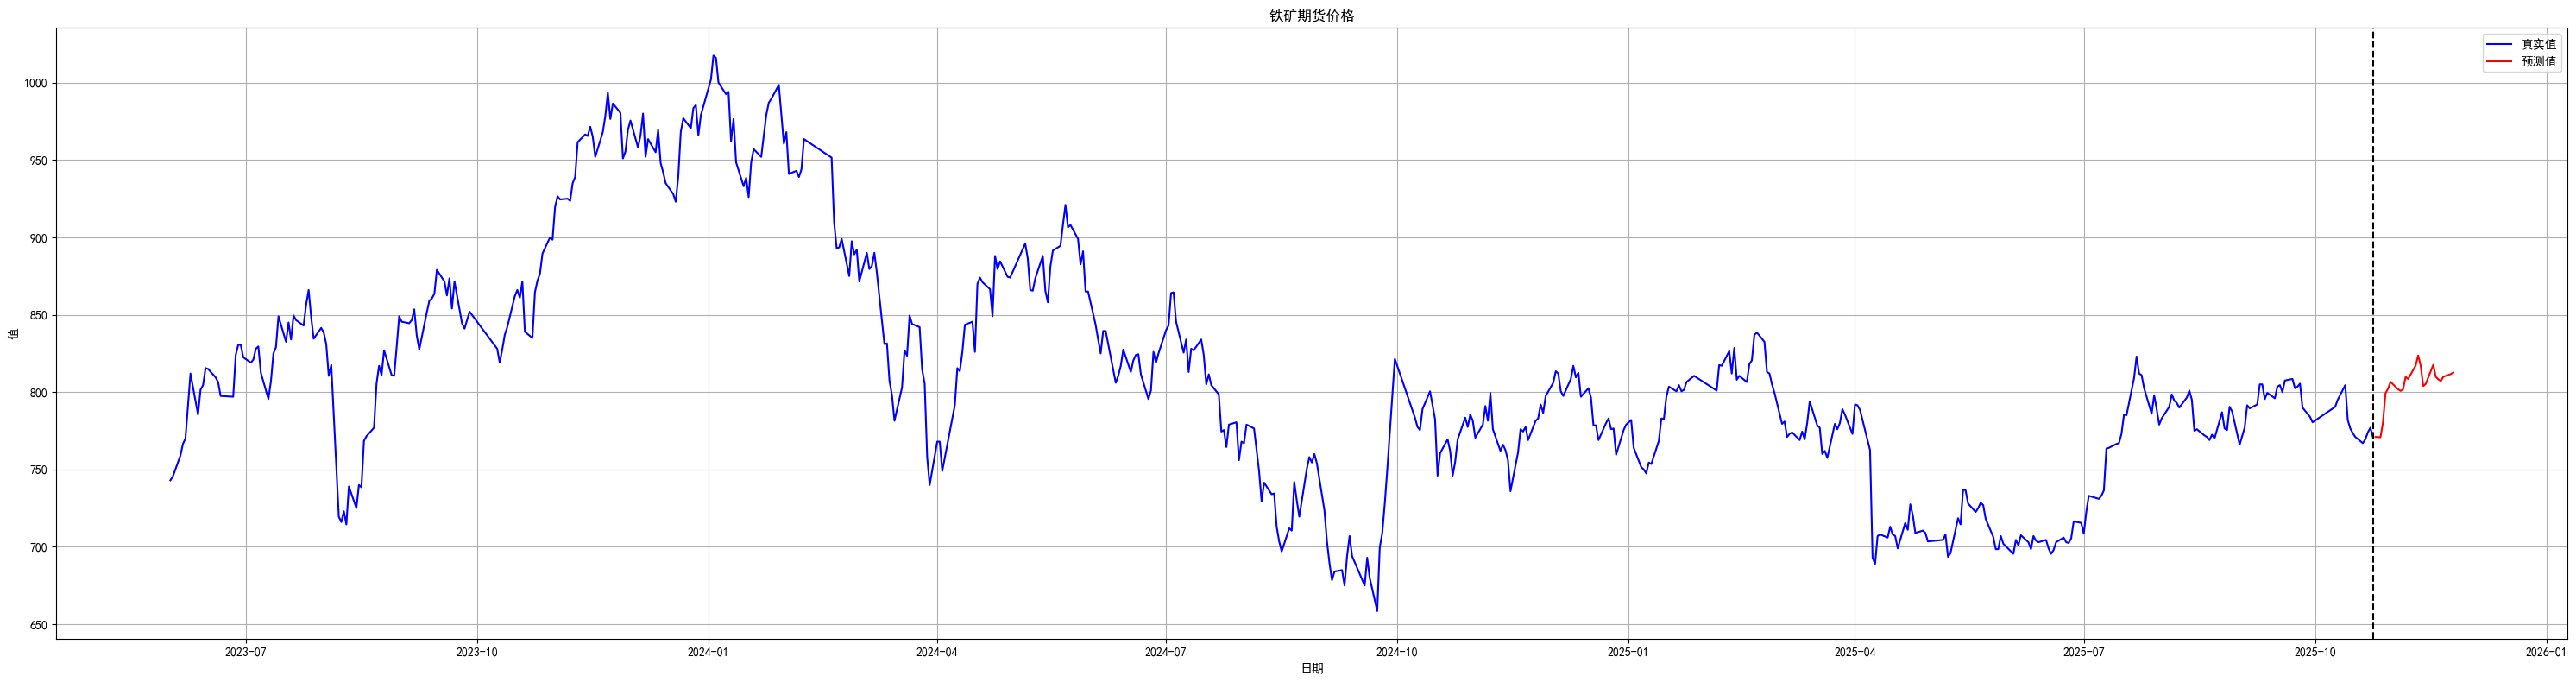

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['铁矿期货价格'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['铁矿期货价格_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('铁矿期货价格')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '铁矿期货价格']]
historical_monthly.columns = ['Date', '铁矿期货价格']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '铁矿期货价格_预测']]
forecast_monthly.columns = ['Date', '铁矿期货价格_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/铁矿期货价格_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,铁矿期货价格,铁矿期货价格_预测
30,2025/12/31,NaN,NaN
29,2025/11/30,NaN,809.820682
28,2025/10/31,779.291667,787.018761
27,2025/09/30,794.477273,796.624869
26,2025/08/31,784.023810,781.299793
25,2025/07/31,770.043478,770.999998
24,2025/06/30,703.650000,707.499921
23,2025/05/31,714.210526,710.999694
22,2025/04/30,722.428571,705.333068
21,2025/03/31,775.404762,777.749773


---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "铁矿期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "详情页"
identifier = "铁矿期货价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
